<h1 style='color:blue'><center>Music Generation using Symbolic Representation with Generative Adversarial Networks (GANs)</center></h1>

---

<b style='color:DodgerBlue'><center>Mughees Asif – 180288337</center></b>
<i style='color:rgb(0, 122, 172)'><center>ECS7022P - Computational Creativity</center></i>
<i style='color:rgb(0, 122, 172)'><center>School of Electronic Engineering and Computer Science</center></i>
<i style='color:rgb(0, 122, 172)'><center> Queen Mary, University of London</center></i>

<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/chopin_intro.jpg?token=GHSAT0AAAAAABS7Z352EPPBH2EJXFHK3NMCYSR24UQ" alt="chopin" style="width: 500px;"/>

## Abstract

Domain-style transfer for text, images, and music, has recently gained traction to enable
creative and original digital content generation. The current trends in research for musical
generation align with using deep neural networks due to the vast computational power
and feasibility for producing varying styles of content. Following this light, the author
has investigated and implemented the usage of Generative Adversarial Networks (GANs)
with the Wasserstein Loss function to generate original musical snippets using symbolic
notation. The dataset was sourced in a piano roll format, a widely used and accepted
form of representing various musical tones and pitches. The GAN system was trained
and tested in various configurations that show promising results. The generation of the
output was aided by adding accompaniments that augment the original input samples
with different tones and pitches to produce qualitatively pleasing music content.


<div class="alert alert-block alert-danger">
<b>Note:</b> The proceeding notebook has been designed using techniques from the <a href='https://aws.amazon.com/deepcomposer/'>AWS Deepcomposer</a> samples <a href='https://stackoverflow.com/questions/17531684/n-grams-in-python-four-five-six-grams'>repository</a>.
</div>

## Contents<a class="anchor" id="contents"></a>

---

**1** &nbsp;&nbsp;**[Download packages](#dw-dep)**<br>
**2** &nbsp;&nbsp;**[Import dependencies](#imports)**<br>
**3** &nbsp;&nbsp;**[Data processing](#preprocess-data)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1&nbsp;&nbsp;*[Output directories](#save-output)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2&nbsp;&nbsp;*[Sample the data](#sample-data)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3&nbsp;&nbsp;*[Data representation](#data-representation)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4&nbsp;&nbsp;*[Prepare the data](#loaddata)*<br>
**4** &nbsp;&nbsp;**[Generative Adversarial Network](#gan)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1&nbsp;&nbsp;*[Generator](#generator)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2&nbsp;&nbsp;*[Discriminator](#discriminator)*<br>
**5** &nbsp;&nbsp;**[Training](#training)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1&nbsp;&nbsp;*[Optimiser](#optimiser)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2&nbsp;&nbsp;*[Save checkpoints](#chkpt)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3&nbsp;&nbsp;*[Loss](#loss)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.1&nbsp;&nbsp;*[Generator](#generator-train)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.2&nbsp;&nbsp;*[Discriminator](#discriminator-train)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.4&nbsp;&nbsp;*[Experimentation](#testing)*<br>
**6** &nbsp;&nbsp;**[Results](#results)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.1&nbsp;&nbsp;*[Live](#live)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.2&nbsp;&nbsp;*[Recorded](#recorded)*<br>
**7** &nbsp;&nbsp;**[References](#references)**<br>

<div class="alert alert-block alert-info">
<b>Tip:</b> To return to the contents, press the 🔝 icon.</div>

## 1&nbsp;&nbsp;Download packages <a class="anchor" id="dw-dep"></a> [🔝](#contents)

This section downloads the necessary packages needed to develop the GAN system.

In [1]:
print('Downloading dependencies...')

!pip install -q numpy
!pip install -q scipy
!pip install -q matplotlib
!pip install -q ipython
!pip install -q pypianoroll
print('Almost done...')
!pip install -q tensorflow==1.15.0

print('Dependencies downloaded and ready!')

Almost done...
Dependencies downloaded and ready!


ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0)
ERROR: No matching distribution found for tensorflow==1.15.0


## 2&nbsp;&nbsp;Import dependencies <a class="anchor" id="imports"></a> [🔝](#contents)

This section imports the necessary dependencies needed to execute this notebook.

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The notebook relies on several utility functions that are present <a href='https://github.com/mughees-asif/music-generation-gan/tree/master/utils'>here</a>. Additionally, <b>ensure</b> to use the mentioned TensorFlow version, otherwise several dependency issues will arise.
</div>

In [3]:
print('Importing necessary dependencies...')

# Main imports
import os 
import numpy as np
from PIL import Image
import pypianoroll
import scipy.stats
import pickle
import music21
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.enable_eager_execution()

# Utility imports 
from utils import display_utils, metrics_utils, path_utils, inference_utils, midi_utils

%matplotlib inline

print('Ready!')

Importing necessary dependencies...
Ready!


## 3&nbsp;&nbsp;Data processing <a class="anchor" id="preprocess-data"></a> [🔝](#contents)

This section will highlight the loading of the data for neural network training.

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The dataset in <code>NumPy</code> array style is available <a href='https://github.com/mughees-asif/music-generation-gan/tree/master/datasets'>here</a>.
</div>

### 3.1 Output directories <a class="anchor" id="save-output"></a> 

In [ ]:
print('Setting up the folder structure to save the output...')

root_dir = './output'

# Save checkpoint generated during training
check_dir = os.path.join(root_dir, 'load_saved')

# Save MIDI files during training
sample_dir = os.path.join(root_dir, 'saved_samples')

# Create directories
make_dir = [check_dir, sample_dir]
for i in range(len(make_dir)):
    os.makedirs(make_dir[i], exist_ok=True)

print('Done!')

### 3.2 *Sample the data* <a class="anchor" id="sample-data"></a>

In [6]:
# Play a sample `MIDI` file to hear the original tones
display_utils.playmidi('./original_midi/MIDI-0.mid')

### 3.3 *Data representation* <a class="anchor" id="data-representation"></a>

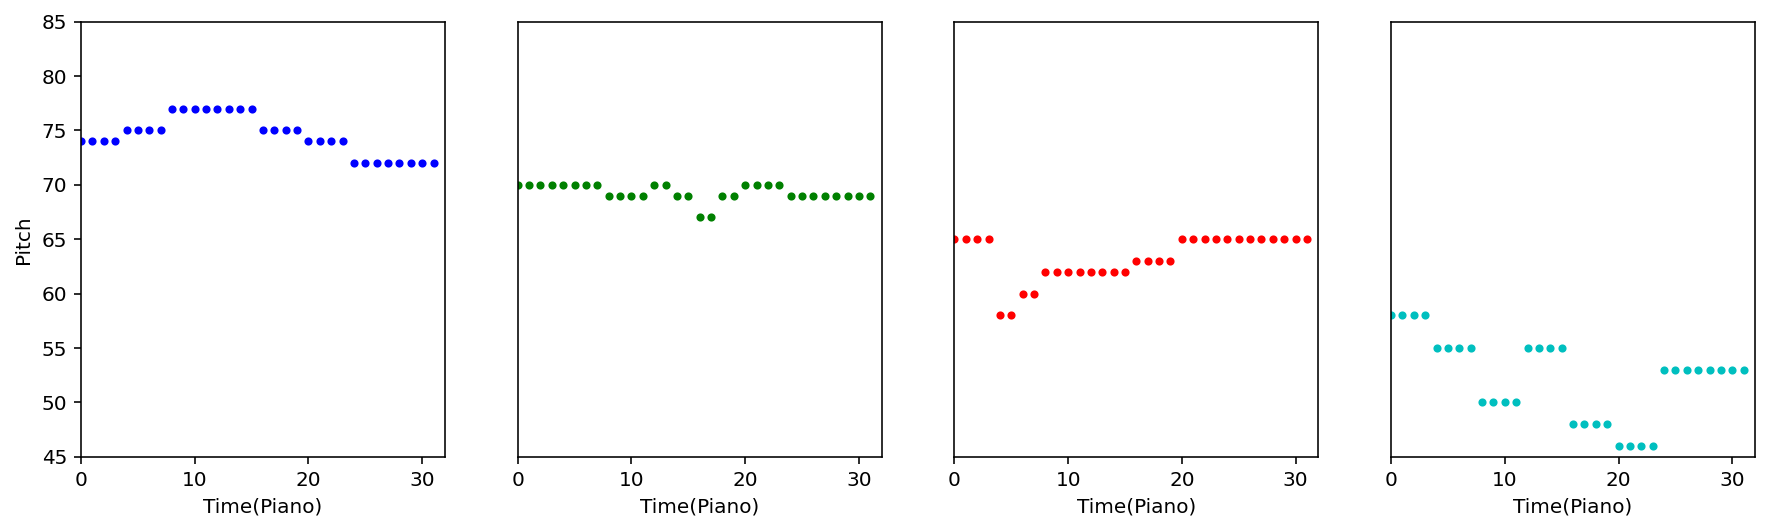

In [7]:
# Load the dataset
training_data = np.load('./dataset/train.npy')

# Display piano roll format of the training data
display_utils.show_pianoroll(training_data)

### 3.4 *Prepare the data* <a class="anchor" id="load-data"></a>

In [8]:
# Load dataset
filename = './dataset/train.npy'
data = np.load(filename)
data = np.asarray(data, dtype=np.float32)

# Convert NumPy array into tensors for training
dataset = tf.data.Dataset.from_tensor_slices(data)

# Shuffle the dataset to add variablity 
dataset = dataset.shuffle(1000).repeat()

# Init batch size
dataset = dataset.batch(64, drop_remainder=True)

# Reduce idle time by prefetching batches
dataset = dataset.prefetch(4)

## 4&nbsp;&nbsp;Generative Adversarial Network (GAN)<a class="anchor" id="gan"></a> [🔝](#contents)

<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/gan.png?token=GHSAT0AAAAAABS7Z352VMPISW442TNVUA26YSZSEJA" alt="gan" style="width: 750px;"/>
<h5 align="center"> Figure: GAN Architecture<sup>1</sup></h5>

GANs are unsupervised neural network models that use two competing supervised sub-models (a generator $\mathcal{G}$, and a discriminator $\mathcal{D}$) to generate deep representations of the input data without the explicit need for annotations<sup>1</sup>. The two sub-models work in concert to develop high-dimensional distributions of the input data that generalises well on unseen samples.

\begin{align}
    \min_\mathcal{G} \max_\mathcal{D} V(\mathcal{G},\mathcal{D}) = \mathcal{E}_{x \backsim p_{x}(x)}[\log{\mathcal{D}(x)}] +  \mathcal{E}_{z \backsim p_{z}(z)}[1-\log{\mathcal{D}(\mathcal{G}(z))}]
\end{align}

where:

|  |  | 
| :--- | :--- | 
| $\mathcal{D}(x)$ | represents the probability that $x$ is from the data and not $p_g$. | 
| $\mathcal{E}_{x \backsim p_{x}(x)}[\log{\mathcal{D}(x)}]$ | represents the probability that $x$ is from the data and not $p_g$. | 
| $\mathcal{D}(\mathcal{G}(z))$ | denotes $\mathcal{D}$’s objective to correctly estimate the real data. | 
| $\mathcal{D}(x)$ | signifies the probability that a sample is from $x$. | 
| $1-\log{\mathcal{D}(\mathcal{G}(z))}$ | represents the syntheticism of $\mathcal{D}(\mathcal{G}(z))$. | 
| $\mathcal{E}_{z \backsim p_{z}(z)}[1-\log{\mathcal{D}(\mathcal{G}(z))]}$ | denotes $\mathcal{D}$’s objective to correctly estimate the probability of recognising the synthetic data. | 

### 4.1 *Generator* <a class="anchor" id="generator"></a>

<img src="https://raw.githubusercontent.com/aws-samples/aws-deepcomposer-samples/ef66010dc65d9a38b5c8fcb2e7fdf9cde01ee066/gan/images/dgen.png" alt="gan_generator" style="width: 750px;"/>
<h5 align="center"> Figure: The generator $\mathcal{G}$ model based on the U-net architecture<sup>2</sup></h5>

The generator $\mathcal{G}$ "$\ldots$transforms a random noise vector into a synthetic sample, which resembles real samples drawn from a distribution of the real content"<sup>3</sup>.

The U-net architecture is an extension of the convolutional neural network (CNN) where pooling operations are used instead of upsampling operators, allowing for precise semantic segmentation and classification of an input image<sup>4</sup>. 

In [9]:
  def generator_(condition_input_shape=(32, 128, 1), filters=64,
                    instruments=4, latent_shape=(2, 8, 512)):
    """
    Builds and returns a generator model.
    """
    c_input = tf.keras.layers.Input(shape=condition_input_shape)
    z_input = tf.keras.layers.Input(shape=latent_shape)

    #### Basic Downsampling Block ####
    # d1
    d1 = tf.keras.layers.Conv2D(filters, 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(c_input)
    d1 = tf.keras.layers.LeakyReLU(alpha=0.2)(d1)

    # d2
    d2 = tf.keras.layers.Conv2D((filters * 2), 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(d1)
    d2 = tf.keras.layers.LeakyReLU(alpha=0.2)(d2)
    d2 = tf.keras.layers.BatchNormalization(momentum=0.8)(d2)
    
    # d3
    d3 = tf.keras.layers.Conv2D((filters * 4), 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(d2)
    d3 = tf.keras.layers.LeakyReLU(alpha=0.2)(d3)
    d3 = tf.keras.layers.BatchNormalization(momentum=0.8)(d3)
    
    # d4
    d4 = tf.keras.layers.Conv2D((filters * 8), 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(d3)
    d4 = tf.keras.layers.LeakyReLU(alpha=0.2)(d4)
    d4 = tf.keras.layers.BatchNormalization(momentum=0.8)(d4)
    d4 = tf.keras.layers.Concatenate(axis=-1)([d4, z_input])
    
    #### Basic Upsampling Block ####
    # u1
    u1 = tf.keras.layers.UpSampling2D(size=2)(d4)
    u1 = tf.keras.layers.Conv2D((filters * 4), 
                                kernel_size=4, 
                                strides=1,
                                padding='same')(u1)
    u1 = tf.keras.layers.BatchNormalization(momentum=0.8)(u1)
    u1 = tf.keras.layers.ReLU()(u1)
    u1 = tf.keras.layers.Dropout(0)(u1)
    u1 = tf.keras.layers.Concatenate()([u1, d3])
    
    # u2
    u2 = tf.keras.layers.UpSampling2D(size=2)(u1)
    u2 = tf.keras.layers.Conv2D((filters * 2), 
                                kernel_size=4, 
                                strides=1,
                                padding='same')(u2)
    u2 = tf.keras.layers.BatchNormalization(momentum=0.8)(u2)
    u2 = tf.keras.layers.ReLU()(u2)
    u2 = tf.keras.layers.Dropout(0)(u2)
    u2 = tf.keras.layers.Concatenate()([u2, d2])    
    
    # u3
    u3 = tf.keras.layers.UpSampling2D(size=2)(u2)
    u3 = tf.keras.layers.Conv2D((filters), 
                                kernel_size=4, 
                                strides=1,
                                padding='same')(u3)
    u3 = tf.keras.layers.BatchNormalization(momentum=0.8)(u3)
    u3 = tf.keras.layers.ReLU()(u3)
    u3 = tf.keras.layers.Dropout(0)(u3)
    u3 = tf.keras.layers.Concatenate()([u3, d1])
    
    # u4
    u4 = tf.keras.layers.UpSampling2D(size=2)(u3)
    output = tf.keras.layers.Conv2D(instruments, 
                                    kernel_size=4, 
                                    strides=1,
                                    padding='same', 
                                    activation='tanh')(u4)  # 32, 128, 4

    generator = tf.keras.models.Model(
        [c_input, z_input], 
        output, 
        name='Generator'
    )

    return generator

# Initialise generator
generator = generator_()
# View summary of the model
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 16, 64, 64)   1088        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 32, 128)   131200      ['leaky_re_lu[0][0]']    

Total params: 8,273,540
Trainable params: 8,270,852
Non-trainable params: 2,688
__________________________________________________________________________________________________


### 4.2 *Discriminator* <a class="anchor" id="discriminator"></a>

<img src="https://raw.githubusercontent.com/aws-samples/aws-deepcomposer-samples/ef66010dc65d9a38b5c8fcb2e7fdf9cde01ee066/gan/images/ddis.png" alt="gan_discriminator" style="width: 750px;"/>
<h5 align="center"> Figure: The discriminator $\mathcal{D}$ model based on the U-net architecture<sup>2</sup></h5>

The discriminator $\mathcal{D}$ "$\ldots$estimates the probability that a sample came from the real data rather than from the generator $\mathcal{G}$"<sup>3</sup>.

In [11]:
def discriminator_(pianoroll_shape=(32, 128, 4), filters=64):
    """
    Builds and returns a discriminator model.
    """
    condition_input_shape = (32,128,1)
    groundtruth_pianoroll = tf.keras.layers.Input(shape=pianoroll_shape)
    condition_input = tf.keras.layers.Input(shape=condition_input_shape)
    combined_imgs = tf.keras.layers.Concatenate(axis=-1)([groundtruth_pianoroll, condition_input])


    # d1: Discriminator does not use batch-norm
    d1 = tf.keras.layers.Conv2D(filters, 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(combined_imgs)
    d1 = tf.keras.layers.LeakyReLU(alpha=0.2)(d1) 
    
    # d2
    d2 = tf.keras.layers.Conv2D((filters * 2), 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(d1)
    d2 = tf.keras.layers.LeakyReLU(alpha=0.2)(d2) 
    
    # d3
    d3 = tf.keras.layers.Conv2D((filters * 4), 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(d2)
    d3 = tf.keras.layers.LeakyReLU(alpha=0.2)(d3) 
    
    # d4
    d4 = tf.keras.layers.Conv2D((filters * 8), 
                               kernel_size=4, 
                               strides=2,
                               padding='same')(d3)
    d4 = tf.keras.layers.LeakyReLU(alpha=0.2)(d4) 

    x = tf.keras.layers.Flatten()(d4)
    logit = tf.keras.layers.Dense(1)(x)

    discriminator = tf.keras.models.Model(
        [groundtruth_pianoroll, condition_input], 
        logit,                         
        name='Discriminator')
    
    return discriminator

# Initialise discriminator
discriminator = discriminator_()
# View summary of the model
discriminator.summary() 

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 128, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 concatenate_5 (Concatenate)    (None, 32, 128, 5)   0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']    

## 5&nbsp;&nbsp;Training <a class="anchor" id="training"></a> [🔝](#contents)

### 5.1 *Optimiser* <a class="anchor" id="optimiser"></a>

Training the models is executed by searching for the optimization of the objective function via the Adam algorithm<sup>5</sup>. 

In [17]:
# Setup Adam optimizers for both models
generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)

### 5.2 *Save checkpoints* <a class="anchor" id="chkpt"></a>

In [18]:
ckpt = tf.train.Checkpoint(
    generator=generator,
    generator_optimizer=generator_optimizer,
    discriminator=discriminator,
    iscriminator_optimizer=discriminator_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, check_dir, max_to_keep=5)

### 5.3 *Loss* <a class="anchor" id="loss"></a>

Arjovsky et al. proposed the usage of a **Wasserstein loss function with gradient penalty** to improve the interpretability of the loss function and produce samples of higher quality<sup>6</sup>. The Wasserstein metric $\mathcal{W}$ is a measure of the distance between two probability distributions and defined as:

\begin{align}
    \mathcal{W}(p_{z},p_{x}) = \max_{\parallel f \parallel \leq 1} \mathcal{E}_{x \backsim p_z}[f(x)] - \mathcal{E}_{x \backsim p_x}[f(x)]
\end{align}

The gradient of the discriminator is *penalised* to ensure optimal differentiation between the real and synthetic samples<sup>6</sup>. This is achieved by implicitly defining $p_{\hat{x}}$ which represents uniform sampling along straight lines between pair of points drawn from $p_z$ and $p_x$<sup>6</sup>. The resulting loss function $\mathbb{L}$ can be parametrised to allow neural network training with two learnable functions for the discriminator $\mathcal{D}_w$ and generator $\mathcal{G}_{\theta}$:

\begin{align}
    \mathbb{L}(p_{x}, p_{\theta}, p_{\hat{x}}) = \max_{w \in \mathbb{W}} \mathbb{E}_{x \sim \mathbb{p}_x}(\mathcal{D}_w(x)) - \mathbb{E}_{z \sim p(z)}(\mathcal{D}_w(\mathcal{G}_{\theta}(z)) + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{p}_\hat{x}[(\lVert \nabla_{\hat{x}}\mathcal{D}_w(\hat{x}) \rVert_2 -  1)^2]}
\label{eq:1}
\end{align}

#### 5.3.1 *Generator* <a class="anchor" id="generator-train"></a>

In [19]:
@tf.function
def generator_loss(x, condition_track_idx=0):
    """
    Defines and returns the loss of the generator.
    """
    # Real data 
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Latent vectors
    z = tf.random.truncated_normal([64, 2, 8, 512])

    # Update generator weights
    with tf.GradientTape() as tape:
        fake_x = generator((c, z), training=True)
        fake_output = discriminator((fake_x,c), training=False)
        
        # -D(G(z|c))
        ##############################################
        # The generator trains to reduce the distance between 
        # the probability distribution of the synthetic  
        # and the real samples.
        ##############################################
        gen_loss = -tf.reduce_mean(fake_output)

    # Calculate gradients for Generator
    gradients_of_generator = tape.gradient(gen_loss,
                                           generator.trainable_variables)
    # Update Generator
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

#### 5.3.2 *Discriminator* <a class="anchor" id="discriminator-train"></a>

In [41]:
@tf.function
def discriminator_loss(x, condition_track_idx=0):
    """
    Defines and returns the loss of the discriminator.
    """
    # Real data
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Latent vectors
    z = tf.random.truncated_normal([64, 2, 8, 512])

    # Fake sample
    fake_x = generator((c, z), training=False)

    # Update discriminator weights
    with tf.GradientTape() as tape:
        real_output = discriminator((x, c), training=True)
        fake_output = discriminator((fake_x, c), training=True)
        
        # D(G(z|c)) - D(x|c)
        ##############################################
        # The discriminator trains to find the distance between 
        # the probability distribution of the synthetic and 
        # the real samples.
        ##############################################
        discriminator_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)

    # Get the gradients for the real and synthetic samples
    grads_of_discriminator = tape.gradient(discriminator_loss,
                                               discriminator.trainable_variables)
    
    # Update discriminator weights based on gradient penalty loss
    # maximize (D(x|c)) + (1 - D(G(z|c))|c) + (Gradient Penality) 
    with tf.GradientTape() as tape:
        c1 = tf.expand_dims(x[..., 0], -1)
        batch_size = x.get_shape().as_list()[0]
        eps_x = tf.random.uniform(
            [batch_size] + [1] * (len(x.get_shape()) - 1))  
        inter = eps_x * x + (1.0 - eps_x) * fake_x

        with tf.GradientTape() as g:
            g.watch(inter)
            disc_inter_output = discriminator((inter, c1), training=True)
        grads = g.gradient(disc_inter_output, inter)
        slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grads), axis=0))
        gp_loss = tf.reduce_mean(tf.square(slopes - 1.0))        
        gp_loss *= 10.0

    # Get the gradient penalty for both samples
    grads_gp = tape.gradient(gp_loss, discriminator.trainable_variables)
    gradients_of_discriminator = [g + ggp for g, ggp in
                                  zip(grads_of_discriminator, grads_gp)
                                  if ggp is not None]

    # Update discriminator based on gradients
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (discriminator_loss + gp_loss)

### 5.4 *Experimentation* <a class="anchor" id="testing"></a>

The two competing models, $\mathcal{G}$ and $\mathcal{D}$, run in a conditional loop which does not terminate until the defined number of iterations. The $\mathcal{G}$ takes a sample from the real data and synthesizes several new multitrack piano roll samples with added accompaniments. The $\mathcal{D}$ model takes the new samples and predicts how much tonal deviation exists between the real and synthetic samples. This information is fed back to the $\mathcal{G}$, which updates the weights (using the Wasserstein Loss function with Gradient penalty) to bring the next synthetic samples closer to the real samples. 

In [42]:
# Load 10 input samples from the dataset and 10 random latent vectors
sample_x, sample_z = inference_utils.load_melody_samples(n_sample=10)

# Training iterations
iterations = 1000

# Update discriminator n times per generator update 
update_generator_per_discriminator_update = 5

# Determine input track
sample_c = tf.expand_dims(sample_x[..., 0], -1)

# Intialise metric management
metrics_utils.metrics_manager.initialize()

# Save both losses
d_losses = []
g_losses = []

# Dataset iterator
it = iter(dataset)

# Training
for iteration in range(iterations):
    # Train discriminator
    for _ in range(update_generator_per_discriminator_update):
        # Generator loss
        g_loss = generator_loss(next(it))
        # Discriminator loss
        d_loss = discriminator_loss(next(it))
        
        # Save Losses for visualisation
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Output training stats
        if iteration % 20 == 0:
            print('Iteration #{}, d_loss={:.2f}, g_loss={:.2f}'.format(iteration, d_loss, g_loss))

        # Save checkpoints, music metrics, generated output
        if iteration < 100 or iteration % 50 == 0 :
            fake_sample_x = generator((sample_c, sample_z), training=False)
            metrics_utils.metrics_manager.append_metrics_for_iteration(fake_sample_x.numpy(), iteration)

            if iteration % 50 == 0:
                ckpt_manager.save(checkpoint_number=iteration) 

                fake_sample_x = fake_sample_x.numpy()
                # plot the pianoroll
                display_utils.plot_pianoroll(iteration, sample_x[:4], fake_sample_x[:4], save_dir=sample_dir)
                # generate the midi
                destination_path = path_utils.generated_midi_path_for_iteration(iteration, saveto_dir=sample_dir)
#                 midi_utils.save_pianoroll_as_midi(fake_sample_x[:4], destination_path=destination_path)

Loaded 10 melody samples
Iteration #1, d_loss=-258764.88, g_loss=-238858.12
Iteration #1, d_loss=-328907.69, g_loss=-342386.12
Iteration #1, d_loss=-233976.50, g_loss=-300713.69
Iteration #1, d_loss=-267617.62, g_loss=-257948.50
Iteration #1, d_loss=-224109.56, g_loss=-221424.78
Iteration #1, d_loss=-272556.12, g_loss=-227617.12
Iteration #1, d_loss=-292313.38, g_loss=-271897.22
Iteration #1, d_loss=-207756.38, g_loss=-265494.81


KeyboardInterrupt: 

## 6&nbsp;&nbsp;Results <a class="anchor" id="results"></a> [🔝](#contents)

### 6.1 Live <a class="anchor" id="live"></a>

The following output is from the above training.

In [ ]:
display_utils.plot_loss_logs(g_losses, d_losses, figsize=(15, 5), smoothing=0.01)

In [ ]:
metrics_utils.metrics_manager.set_reference_metrics(training_data)
metrics_utils.metrics_manager.plot_metrics()

### 6.2 Recorded <a class="anchor" id="recorded"></a>

The following results were recorded over the course of the training and displays the total $\mathcal{G}$ \& $\mathcal{D}$ losses with various configurations of the training parameters.

#### 1000 iterations; no update to $\mathcal{D}$ per $\mathcal{G}$ output
<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/1000_iters_no-update.png?token=GHSAT0AAAAAABS7Z353O24NYLVCPN3DJP2QYSR2TJQ" alt="gan-train-1" style="width: 750px;"/>
<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/1000_metrics_no-update.png?token=GHSAT0AAAAAABS7Z352E5V24WK4S3B3RY6MYSR22GQ" alt="gan-metric-1" style="width: 750px;"/>

#### 2000 iterations; 2 updates to $\mathcal{D}$ per $\mathcal{G}$ output
<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/1000_iters_2-update.png?token=GHSAT0AAAAAABS7Z352FBKUFJ2SB23OACQAYSR2TYA" alt="gan-train-2" style="width: 750px;"/>
<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/1000_metrics_2-update.png?token=GHSAT0AAAAAABS7Z3527N3G34XJM267QVM2YSR22IQ" alt="gan-metric-2" style="width: 750px;"/>

#### 5000 iterations; 5 updates to $\mathcal{D}$ per $\mathcal{G}$ output
<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/1000_iters_5-update.png?token=GHSAT0AAAAAABS7Z3532BIG434QMHKH75UKYSR2TVQ" alt="gan-train-3" style="width: 750px;"/>
<img src="https://raw.githubusercontent.com/mughees-asif/music-generation-gan/master/images/1000_metrics_5-update.png?token=GHSAT0AAAAAABS7Z353ZB4SW2QE6DRAJ4P2YSR22KA" alt="gan-metric-3" style="width: 750px;"/>

## 7&nbsp;&nbsp;References <a class="anchor" id="references"></a> [🔝](#contents)


<sup>1</sup>Antonia Creswell, Tom White, Vincent Dumoulin, Kai Arulkumaran, Biswa Sengupta, and Anil A Bharath. “Generative Adversarial Networks: An Overview”. In: *IEEE Signal Processing Magazine* 35.1 (2018), pp. 53–65.<br/>
<sup>2</sup><a href='https://github.com/aws-samples/aws-deepcomposer-samples/tree/master/gan/images'>AWS Deepcomposer samples</a>.<br/>
<sup>3</sup>Jean-Pierre Briot. “From artificial neural networks to deep learning for music generation: history, concepts and trends”. In: *Neural Computing and Applications 33.1* (2021), pp. 39–65.<br/>
<sup>4</sup>Olaf Ronneberger, Philipp Fischer, and Thomas Brox. “U-net: Convolutional networks for biomedical image segmentation”. In: *International Conference on Medical Image Computing and Computer-Assisted Intervention*. Springer. 2015, pp. 234–241.<br/>
<sup>5</sup>Kingma, D.P. and Ba, J., 2014. Adam: A method for stochastic optimization. *arXiv preprint arXiv:1412.6980*.<br/>
<sup>6</sup>Martin Arjovsky, Soumith Chintala, and Léon Bottou. “Wasserstein Generative Adversarial Networks”. In: *Proceedings of the 34th International Conference on Machine Learning*. Ed. by Doina Precup and Yee Whye Teh. Vol. 70. Proceedings of Machine Learning Research. PMLR, June 2017, pp. 214–223. url: https://proceedings.mlr.press/v70/arjovsky17a.html.

<h1 style='color:purple'><center><a href='#contents'>🔝</a>&#8592;&#8592;&#8592;&#8592; END &#8594;&#8594;&#8594;&#8594;<a href='#contents'>🔝</a></center></h1>